<a href="https://colab.research.google.com/github/ju-ki/atma10/blob/master/exp9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText xfeat category_encoders texthero  umap transformers MulticoreTSNE
!rm -rf fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 40.88 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.


In [3]:
import os 
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import texthero as hero
from fasttext import load_model

from contextlib import contextmanager
from pathlib import Path
from typing import Optional

from gensim import corpora, models
from gensim.models import word2vec, KeyedVectors
from geopy.geocoders import Nominatim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()
sns.set()
CODE_PATH = "/content/drive/MyDrive/atmacup10/code/"
INPUT_PATH = "/content/drive/MyDrive/atmacup10/data/raw/"
OUTPUT_PAHT = "/content/drive/MyDrive/atmacup10/data/submission/"

os.chdir(CODE_PATH)

from feature_engine import *
from nlp_feature import *
from util import AbstractBaseBlock, WrapperBlock, Util

train_df = pd.read_csv(INPUT_PATH + "train.csv")
test_df = pd.read_csv(INPUT_PATH + "test.csv")
whole_df = pd.concat([train_df, test_df])

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [4]:
import inspect

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper

@cachable
def read_csv(name):

    if '.csv' not in name:
        name = name + '.csv'

    return pd.read_csv(os.path.join(INPUT_PATH, name))

def whole_df():
  return pd.concat([read_csv("train"), read_csv("test")], ignore_index=True).reset_index

OBJECT_ID = "object_id"
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

In [5]:
technique = pd.read_csv(INPUT_PATH + "technique.csv")
place_df = pd.read_csv(INPUT_PATH + "place.csv")
historical_person = pd.read_csv(INPUT_PATH + "historical_person.csv")
object_collection = pd.read_csv(INPUT_PATH + "object_collection.csv")
material = pd.read_csv(INPUT_PATH + "material.csv")
principal_maker = pd.read_csv(INPUT_PATH + 'principal_maker.csv')
principal_maker_occupation = pd.read_csv(INPUT_PATH+ 'principal_maker_occupation.csv')
color_df = pd.read_csv(INPUT_PATH + "color.csv")
palette = pd.read_csv(INPUT_PATH + 'palette.csv')
maker = pd.read_csv(INPUT_PATH + 'maker.csv')

In [6]:
# place_df["trimmed_name"] = place_df["name"].str.strip("?")
# place_df["obscure_name"] = place_df["name"].str.startswith("?").astype(int)

In [7]:
# def place2country(address):
#     geolocator = Nominatim(user_agent='sample', timeout=200)
#     loc = geolocator.geocode(address, language='en')
#     coordinates = (loc.latitude, loc.longitude)
#     location = geolocator.reverse(coordinates, language='en')
#     country = location.raw['address']['country']
#     return country

# place_list = place_df['trimmed_name'].unique()
# country_dict = {}
# for place in tqdm(place_list):
#     try:
#         country = place2country(place)
#         country_dict[place] = country
#     except:
#         # 国名を取得できない場合はnan
#         print(place)
#         country_dict[place] = np.nan
# place_df['country_name'] = place_df['trimmed_name'].map(country_dict)
# place_df.to_csv(INPUT_PATH + "place.csv", index=False)

In [8]:
place_df["obscure_name"].value_counts()

0    17081
1      605
Name: obscure_name, dtype: int64

In [9]:
def merge_color(input_df: pd.DataFrame):
    agg_df = (
        color_df
            .groupby('object_id')['percentage']
            .agg(['mean', 'min', 'max', 'std', 'count', 'var', 'skew'])
            .add_prefix('color_percentage_')
    )
    output_df = input_df.merge(agg_df, left_on='object_id', right_index=True, how='left')
    # 一番占める色のpercentageと色
    important_color_info = (
        color_df
            .groupby('object_id', as_index=False)['percentage'].max()
            .merge(color_df, left_on=['object_id', 'percentage'], right_on=['object_id', 'percentage'])
            .groupby(['object_id', 'percentage'], as_index=False)['hex'].max()
            .set_index('object_id')
            .add_prefix('color_important_info_')
    )
    output_df = output_df.merge(important_color_info, left_on='object_id', right_index=True, how='left')
    
    return output_df

def merge_material(input_df: pd.DataFrame):
    
    dummy_df = (
        pd.get_dummies(material, columns=['name'], prefix='material_dummy')
            .groupby('object_id')
            .sum()
    )
    output_df = input_df.merge(dummy_df, left_on='object_id', right_index=True, how='left')
    material_num = material['object_id'].value_counts()
    output_df['material_num'] = output_df['object_id'].map(material_num)
    
    unique_materials = material.groupby('object_id').min().rename(columns={'name': 'unique_material'})
    output_df = output_df.merge(unique_materials, left_on='object_id', right_index=True, how='left')

    
    return output_df

def merge_palette(input_df: pd.DataFrame):
    # 構成要素のRGBの平均みたいな表現
    # この絵を1色で表すと何色？的な
    palette['r_ratio'] = palette['color_r'] * palette['ratio']
    palette['g_ratio'] = palette['color_g'] * palette['ratio']
    palette['b_ratio'] = palette['color_b'] * palette['ratio']
    agg_df = (
        palette
            .groupby('object_id')
            .agg({'r_ratio': 'sum', 'g_ratio': 'sum', 'b_ratio': 'sum'})
            .add_prefix('palette_summary_')
    )
    output_df = input_df.merge(agg_df, left_on='object_id', right_index=True, how='left')
    
    # 代表値
    #important_color_info = (
    #    palette
    #        .groupby('object_id', as_index=False)['ratio'].max()
    #        .merge(palette, left_on=['object_id', 'ratio'], right_on=['object_id', 'ratio'])
    #        .groupby(['object_id', 'ratio'], as_index=False)['color_r', 'color_g', 'color_b'].max()
    #        .set_index('object_id')
    #        .add_prefix('palette_important_info_')
    #)
    #output_df = output_df.merge(important_color_info, left_on='object_id', right_index=True, how='left')
    
    return output_df

def merge_historical_person(input_df: pd.DataFrame):
    historical_person['historical_person_name_length'] = historical_person['name'].str.len()
    agg_df = (
        historical_person
            .groupby('object_id')['historical_person_name_length']
            .agg(['mean', 'min', 'max', 'std', 'var', 'skew'])
            .add_prefix('historical_person_length_')
    )
    # 登場人物の数
    person_cnt = historical_person['object_id'].value_counts().rename('historical_person_cnt')
    output_df = (
        input_df
            .merge(agg_df, left_on='object_id', right_index=True, how='left')
            .merge(person_cnt, left_on='object_id', right_index=True, how='left')
    )
    output_df['historical_person_cnt'] = output_df['historical_person_cnt'].fillna(0)
    
    historical_person.drop(['historical_person_name_length'], axis=1, inplace=True)
    freq = historical_person['name'].value_counts()
    high_freq_persons = freq[freq >= 9].index.tolist()
    historical_person['name_high_freq'] = historical_person['name'].apply(lambda x: x if x in high_freq_persons else np.nan)
    dummy_df = (
        pd.get_dummies(historical_person, columns=['name_high_freq'])
            .drop(['name'], axis=1)
            .groupby(['object_id']).agg(sum)
    )

    historical_person['ce_person'] = historical_person['name'].map(historical_person['name'].value_counts())
    agg_df = historical_person.groupby('object_id')['ce_person'].agg(['mean', 'min', 'max', 'std', 'var', 'skew'])
    historical_person.drop('ce_person', axis=1, inplace=True)
    
    output_df = output_df.merge(dummy_df, how='left', left_on='object_id', right_index=True)
    output_df = output_df.merge(agg_df, how='left', left_on='object_id', right_index=True)

    
    return output_df

def merge_object_collection(input_df: pd.DataFrame):
    dummy_df = (
        pd.get_dummies(object_collection, columns=['name'], prefix='object_collection_dummy')
            .groupby('object_id')
            .sum()
    )
    output_df = input_df.merge(dummy_df, left_on='object_id', right_index=True, how='left')
    
    unique_collections = object_collection.groupby('object_id').min().rename(columns={'name': 'unique_collection'})
    output_df = output_df.merge(unique_collections, left_on='object_id', right_index=True, how='left')
    collection_num = object_collection['object_id'].value_counts()
    output_df['collections_num'] = output_df['object_id'].map(collection_num)
    
    return output_df

def merge_production_place(input_df: pd.DataFrame):
    dummy_df = (
        pd.get_dummies(place_df, columns=['trimmed_name', 'country_name'], prefix=['production_place_dummy_name', 'production_place_dummy_country_name'])
            .drop('name', axis=1)
            .groupby('object_id')
            .sum()
    )
    output_df = input_df.merge(dummy_df, left_on='object_id', right_index=True, how='left')
    unique_names = place_df.groupby('object_id')['trimmed_name'].min().rename('unique_name')
    output_df = output_df.merge(unique_names, left_on='object_id', right_index=True, how='left')
    unique_country_names = place_df.groupby('object_id')['country_name'].min().rename('unique_country_name')
    output_df = output_df.merge(unique_country_names, left_on='object_id', right_index=True, how='left')
    
    return output_df

def merge_technique(input_df: pd.DataFrame):
    dummy_df = (
        pd.get_dummies(technique, columns=['name'], prefix='technique_dummy')
            .groupby('object_id')
            .sum()
    )
    # 使われている技術の数
    tech_cnt = technique['object_id'].value_counts().rename('tech_cnt')
    output_df = (
        input_df
            .merge(dummy_df, left_on='object_id', right_index=True, how='left')
            .merge(tech_cnt, left_on='object_id', right_index=True, how='left')
    )
    
    unique_techs = technique.groupby('object_id').min().rename(columns={'name': 'unique_technique'})
    output_df = output_df.merge(unique_techs, left_on='object_id', right_index=True, how='left')

    return output_df

def merge_maker(input_df: pd.DataFrame):
    maker['year_of_birth'] = maker['date_of_birth'].str[:4].fillna(-1).astype(int).replace(-1, np.nan)
    maker['year_of_death'] = maker['date_of_death'].str[:4].fillna(-1).astype(int).replace(-1, np.nan)
    maker['age_of_death'] = maker['year_of_death'] - maker['year_of_birth']
    output_df = (
        input_df
            .merge(maker.drop(['date_of_birth', 'date_of_death'], axis=1), left_on='principal_maker', right_on='name', how='left')
            .drop('name', axis=1)
    )
    
    return output_df

def merge_principal_maker(input_df: pd.DataFrame):
    agg_principal_maker_occupation = pd.get_dummies(principal_maker_occupation, columns=['name'], prefix='occupation').groupby('id').sum()
    merge_df = principal_maker.merge(agg_principal_maker_occupation, how='left', left_on='id', right_index=True)
    agg_df = pd.get_dummies(merge_df, columns=['qualification', 'roles', 'productionPlaces']).drop(['maker_name', 'id'], axis=1).groupby('object_id').sum()
    
    output_df = input_df.merge(agg_df, how='left', left_on='object_id', right_index=True)
    
    principal_maker_num = principal_maker['object_id'].value_counts()
    output_df['principal_maker_num'] = output_df['object_id'].map(principal_maker_num)
    
    return output_df

# def merge_palette_embedding(input_df: pd.DataFrame):
#     return input_df.merge(palette_embeddiing, on='object_id', how='left')

In [10]:
WrapperBlock(merge_maker).fit(train_df)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes,place_of_birth,place_of_death,nationality,year_of_birth,year_of_death,age_of_death
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48,Amsterdam,Amsterdam,NaN,1628.0,1705.0,77.0
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2,Amsterdam,Apeldoorn,NaN,1864.0,1952.0,88.0
2,0017be8caa87206532cb,4c406890d208fe01f8fb,Portret van een vrouw,"Portret van eenvrouw, zittend naast een tafel.","Portret van een vrouw, Tresling & Comp., 1860 ...",Tresling & Comp.,Tresling & Comp.,h 87mm × w 56mm,NaN,Portret van een vrouw,gift,2007-01-01T00:00:00,"Gift of M.M. Boom, Leiden",1860 - 1880,1860.0,19,1860.0,1880.0,5,NaN,NaN,NaN,NaN,NaN,NaN
3,00181d86ff1a7b95864e,fa0891535500a4973db2,A St Bernard Dog,"Een sint-bernardshond, staand in een landschap...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...",Bernard te Gempt,Bernard te Gempt,h 179cm × w 248cm × t 4cm,NaN,A St Bernard Dog,bequest,1881-01-01T00:00:00,"J. Hilman Bequest, Amsterdam",c. 1850 - c. 1879,1850.0,19,1850.0,1879.0,100,Batenburg,Amsterdam,NaN,1826.0,1879.0,53.0
4,001c52ae28ec106d9cd5,8065ed5063c5887e677d,Woelige zee met zeilschepen,Woelige zee met zeilschepen.,"Woelige zee met zeilschepen, anonymous, 1825 -...",anonymous,anonymous,h 13cm × w 17.5cm × d 0.7cm,NaN,Woelige zee met zeilschepen,unknown,1971-01-01T00:00:00,NaN,1825 - 1874,1825.0,19,1825.0,1874.0,7,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,ffedf8af4fd5b3873164,2e4695e7f3260d52b3e6,De schilder H.W. Mesdag voor een doek,NaN,"De schilder H.W. Mesdag voor een doek, Delboy ...",Delboy & Baer,Delboy & Baer,h 90mm × w 140mm,NaN,De schilder H.W. Mesdag voor een doek H W Mesdag,transfer,1994-01-01T00:00:00,NaN,1900 - 1920,1900.0,19,1900.0,1920.0,4,NaN,NaN,NaN,NaN,NaN,NaN
12022,ffee34705ea44e1a0f79,7aa656a9ef243d93d009,"Kaart van de streek tussen Mannheim en Landau,...","Kaart van de streek tussen Mannheim, Speyer en...","Kaart van de streek tussen Mannheim en Landau,...",Abraham Allard,Abraham Allard,h 245mm × w 278mm,NaN,"Kaart van de streek tussen Mannheim en Landau,...",purchase,1881-01-01T00:00:00,NaN,1701 - 1714,1701.0,18,1701.0,1714.0,0,Amsterdam,Amsterdam,NaN,1676.0,1725.0,49.0
12023,ffefbe1faf771aa4f790,e79c2e74ed17533a7e56,Storm op het IJ aan het Blauwhoofd van Amsterd...,Zeilschepen in de problemen op het IJ ter hoog...,Storm op het IJ aan het Blauwhoofd van Amsterd...,Noach van der Meer (II),Noach van der Meer (II),h 217mm × w 306mm,NaN,Storm op het IJ aan het Blauwhoofd van Amsterd...,transfer,1887-01-01T00:00:00,NaN,1778,1778.0,18,1778.0,1778.0,0,Leiden,Amsterdam,NaN,1741.0,1822.0,81.0
12024,fff08e76cbb969eaddc7,510358b74c1104edbbbd,"Het rad van fortuin, ca. 1689","Het rad van fortuin, ca. 1689. Spotprent op de...","Het rad van fortuin, ca. 1689, Romeyn de Hoogh...",Romeyn de Hooghe,Romeyn de Hooghe,h 560mm × w 405mm,NaN,"Het rad van fortuin, ca. 1689 'T Hedendaags Ra...",purchase,1881-01-01T00:00:00,NaN,1689 - 1690,1689.0,17,1689.0,1690.0,14,Amsterdam,Haarlem,NaN,1645.0,1708.0,63.0


In [11]:
from nlp_feature import *

In [72]:
def preproc_extract_size_from_sub_title(input_df: pd.DataFrame):
    # サイズを抽出する
    # ref: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/
    for axis in ['h', 'w', 't', 'd']:
        column_name = f'size_{axis}'
        size_info = input_df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
        input_df[column_name] = size_info[column_name] # trainにくっつける
        
    # 手動対応
    input_df.loc[input_df['object_id']=='81b0b69b11ad460a19fe', 'size_w'] = 78
    out_df = input_df[["size_h", "size_w", "size_t", "size_d"]].copy()


    
    return out_df

In [73]:
WrapperBlock(preproc_extract_size_from_sub_title).fit(train_df)

,size_h,size_w,size_t,size_d
0,665.0,537.0,25.0,47.0
1,165.0,223.0,NaN,NaN
2,87.0,56.0,NaN,NaN
3,1790.0,2480.0,40.0,NaN
4,130.0,175.0,NaN,7.0
...,...,...,...,...
12021,90.0,140.0,NaN,NaN
12022,245.0,278.0,NaN,NaN
12023,217.0,306.0,NaN,NaN
12024,560.0,405.0,NaN,NaN


In [14]:
import nltk
from sklearn.pipeline import Pipeline

In [15]:
def text_normalization(text):

    # 英語とオランダ語を stopword として指定
    custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

    x = hero.clean(text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])

    return x

class TfidfBlock(AbstractBaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, input_df):
        """tdidfを計算するための全体集合を返す. 
        デフォルトでは fit でわたされた dataframe を使うが, もっと別のデータを使うのも考えられる."""
        return input_df

    def fit(self, input_df, y=None):
        master_df = self.get_master(input_df)
        text = self.preprocess(input_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=10000)),
            ('svd', TruncatedSVD(n_components=50)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_')

In [16]:
TfidfBlock("title").fit(train_df)

,title_tfidf_0,title_tfidf_1,title_tfidf_2,title_tfidf_3,title_tfidf_4,title_tfidf_5,title_tfidf_6,title_tfidf_7,title_tfidf_8,title_tfidf_9,title_tfidf_10,title_tfidf_11,title_tfidf_12,title_tfidf_13,title_tfidf_14,title_tfidf_15,title_tfidf_16,title_tfidf_17,title_tfidf_18,title_tfidf_19,title_tfidf_20,title_tfidf_21,title_tfidf_22,title_tfidf_23,title_tfidf_24,title_tfidf_25,title_tfidf_26,title_tfidf_27,title_tfidf_28,title_tfidf_29,title_tfidf_30,title_tfidf_31,title_tfidf_32,title_tfidf_33,title_tfidf_34,title_tfidf_35,title_tfidf_36,title_tfidf_37,title_tfidf_38,title_tfidf_39,title_tfidf_40,title_tfidf_41,title_tfidf_42,title_tfidf_43,title_tfidf_44,title_tfidf_45,title_tfidf_46,title_tfidf_47,title_tfidf_48,title_tfidf_49
0,5.993525e-07,0.000006,8.934203e-06,0.000014,0.000020,0.000160,0.000121,-0.000117,5.705366e-07,-0.000100,1.527758e-06,0.000019,0.000390,-0.000026,-0.000005,0.000011,0.000139,0.000012,-0.000228,-0.000035,0.000002,0.000019,0.000069,-0.000355,-0.001263,-0.000029,0.000060,0.000668,0.001517,0.002675,0.006867,0.007710,-0.001781,-0.003582,-0.002343,-0.001525,0.000011,-0.001942,-0.001018,-0.004572,0.000083,0.000038,0.000917,0.000223,0.000283,-0.000166,-0.000392,-0.000230,0.001104,0.000558
1,5.688250e-04,-0.000912,7.209885e-04,0.000693,0.001116,-0.000892,0.001850,0.001589,5.758878e-06,0.000150,-2.202507e-04,0.002436,-0.000047,-0.001979,-0.001392,0.000349,-0.000446,-0.000075,-0.000426,-0.000404,0.000062,0.000661,0.000779,0.004170,-0.001235,-0.001200,-0.005359,0.003331,-0.000730,0.001236,-0.000095,0.000385,0.001539,-0.000075,0.001159,-0.002159,0.002874,-0.002966,0.009121,-0.000610,0.000078,-0.002821,0.001476,0.002127,0.005518,0.002521,0.001595,-0.001928,-0.001110,0.006868
2,7.142575e-01,-0.419275,2.797944e-02,0.244602,0.169164,-0.191540,0.320191,0.139943,-2.549916e-04,0.007419,-3.585546e-02,-0.060692,-0.000287,-0.016908,-0.073997,0.004958,-0.111105,0.034366,-0.009602,0.010901,-0.033089,-0.047656,-0.011287,-0.031991,-0.021795,-0.003919,0.007640,-0.011262,0.024037,0.024374,-0.063418,0.042633,0.037568,-0.031801,-0.036958,0.064425,-0.024919,0.009806,0.010083,-0.013199,-0.007586,0.005622,0.000075,-0.030360,0.012603,-0.001046,0.004128,-0.004862,-0.014763,0.013815
3,8.866633e-04,0.001899,1.960079e-03,0.000879,0.005192,-0.000033,0.001524,0.000649,2.840976e-03,-0.000151,-3.231053e-04,0.000393,0.000879,0.000037,0.002769,0.005563,-0.001901,-0.004538,0.005940,0.001069,-0.002948,-0.001569,-0.005675,-0.003271,0.002437,0.006129,0.004991,0.004197,-0.003033,0.009248,0.000822,0.006532,0.018393,-0.001271,-0.007448,0.007868,-0.003289,-0.012442,0.020460,0.026679,0.020547,-0.020287,-0.013879,0.048107,0.004824,0.021660,0.034086,-0.011873,-0.010224,0.010415
4,1.363751e-04,0.000417,7.159765e-03,-0.000604,0.001029,0.006795,-0.001069,0.009902,7.121653e-05,0.002840,-3.689244e-03,0.000757,0.000690,0.000074,0.003546,-0.000714,-0.002131,-0.003211,0.002270,0.001323,-0.000868,0.013061,0.017607,0.002509,-0.006150,0.005031,0.002876,0.021392,0.011884,0.000498,-0.008339,0.018052,-0.005588,0.020316,-0.003127,-0.004982,-0.013596,0.016374,0.032911,-0.006144,0.063999,-0.027845,0.057284,0.007978,-0.027183,0.021622,-0.065317,-0.004228,-0.015134,-0.122412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,5.472955e-03,-0.000047,4.868066e-04,-0.009202,0.030502,-0.004602,0.003520,0.000590,-2.560869e-05,-0.000048,-1.281242e-03,0.001209,0.000096,0.000127,-0.002746,0.002394,-0.003617,-0.007020,-0.003591,-0.004013,0.002323,0.010814,-0.000847,-0.019116,0.015828,0.009775,0.010303,-0.020963,0.000327,0.019279,-0.002588,-0.017153,0.018043,-0.023200,-0.002820,0.010863,0.001867,-0.016197,-0.007482,-0.008973,-0.006333,0.011210,-0.018007,-0.010273,0.007759,0.008189,0.031651,-0.008094,-0.015189,0.005186
12022,5.988584e-04,0.000446,8.088279e-03,0.001092,0.005140,0.059798,0.041448,-0.027236,-1.733540e-03,0.230703,1

In [17]:
class LDAVectrizerBlock(AbstractBaseBlock):

  def __init__(self, columns, num_topics=20):
    self.columns = columns
    self.num_topics = num_topics

  def preprocess(self, input_df):
        x = text_normalization(input_df[self.columns])
        text_list = list(list(x.apply(lambda x: x.split())))
        return x
  def get_corpus(self, text_list):
          return [self.dictionary.doc2bow(tokens) for tokens in text_list]
    
    
  def fit_transform(self, input_df):
      text_list = self.preprocess(input_df[self.columns])
      self.dictionary = corpora.Dictionary(text_list)
      self.dictionary.filter_extremes(no_below=2,no_above=0.2)
      corpus = self.get_corpus(text_list)
      self.model = models.LdaModel(corpus,
                      num_topics=self.num_topics,
                      id2word=self.dictionary,
                      random_state=0
                      )
      output_arr = np.array(self.model.get_document_topics(corpus,minimum_probability=0))[:, :, 1]
      output_df = pd.DataFrame(output_arr, columns=[f'lda_{i}' for i in range(self.num_topics)])
      
      return output_df
  
  def transform(self, input_df):
      text_list = self.preprocess(input_df[self.columns])
      corpus = self.get_corpus(text_list)
      
      output_arr = np.array(self.model.get_document_topics(corpus,minimum_probability=0))[:, :, 1]
      output_df = pd.DataFrame(output_arr, columns=[f'lda_{i}' for i in range(self.num_topics)])
      
      return output_df

In [18]:
train_df = pd.merge(train_df, maker, left_on="principal_maker", right_on="name", how="left")
test_df = pd.merge(test_df, maker, left_on="principal_maker", right_on="name", how="left")


train_df["acquisition_date"] = pd.to_datetime(train_df["acquisition_date"])
train_df["acquisition_date"] = train_df['acquisition_date'].dt.strftime("%Y")

test_df["acquisition_date"] = pd.to_datetime(test_df["acquisition_date"])
test_df["acquisition_date"] = test_df['acquisition_date'].dt.strftime("%Y")

train_df["date_of_birth"] = train_df["date_of_birth"].str[:4]
train_df["date_of_death"] = train_df["date_of_death"].str[:4]
train_df["date_of_birth"] = train_df["date_of_birth"].astype(float)
train_df["date_of_death"] = train_df["date_of_death"].astype(float)


test_df["date_of_birth"] = test_df["date_of_birth"].str[:4]
test_df["date_of_death"] = test_df["date_of_death"].str[:4]
test_df["date_of_birth"] = test_df["date_of_birth"].astype(float)
test_df["date_of_death"] = test_df["date_of_death"].astype(float)


train_df["age"] = train_df["date_of_death"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["age"] = train_df["age"].fillna("NaN")
train_df["age"] = train_df["age"].astype(float)

test_df["age"] = test_df["date_of_death"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["age"] = test_df["age"].fillna("NaN")
test_df["age"] = test_df["age"].astype(float)


train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "date_of_birth"] = "NaN"
train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "date_of_death"] = "NaN"
train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "age"] = "NaN"

test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "date_of_birth"] = "NaN"
test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "date_of_death"] = "NaN"
test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "age"] = "NaN"

train_df["age"] = train_df["age"].astype(float)
test_df["age"] = test_df["age"].astype(float)

train_df["date_of_birth"] = train_df["date_of_birth"].astype(float)
train_df["date_of_death"] = train_df["date_of_death"].astype(float)

test_df["date_of_birth"] = test_df["date_of_birth"].astype(float)
test_df["date_of_death"] = test_df["date_of_death"].astype(float)


#制作期間が長いほど名作なのでは
train_df["period_of_production"] = train_df["dating_year_late"].astype(float) - train_df["dating_year_early"].astype(float)
train_df["period_of_production"] = train_df["period_of_production"].fillna("NaN").astype(float)

#ここの期間が短い（遺作）は評価が高いのでは
train_df["period_between_death_year_and_late_year"] = train_df["date_of_death"].astype(float) - train_df["dating_year_late"].astype(float)
train_df["period_between_death_year_and_late_year"] = train_df["period_between_death_year_and_late_year"].fillna("NaN").astype(float)
#回収されるまでの期間が長ければ名作なのでは
train_df["period_between_acquistion_date_and_date_death"] = train_df["acquisition_date"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["period_between_acquistion_date_and_date_death"] = train_df["period_between_acquistion_date_and_date_death"].fillna("NaN").astype(float)
#幼少期に書かれた作品は評価が良いのでは？
train_df["period_between_date_of_birth_and_dating_year_late"] = train_df["dating_year_late"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["period_between_date_of_birth_and_dating_year_late"] = train_df["period_between_date_of_birth_and_dating_year_late"].fillna("NaN").astype(float)

#制作期間が長いほど名作なのでは
test_df["period_of_production"] = test_df["dating_year_late"].astype(float) - test_df["dating_year_early"].astype(float)
test_df["period_of_production"] = test_df["period_of_production"].fillna("NaN").astype(float)

#ここの期間が短い（遺作）は評価が高いのでは
test_df["period_between_death_year_and_late_year"] = test_df["date_of_death"].astype(float) - test_df["dating_year_late"].astype(float)
test_df["period_between_death_year_and_late_year"] = test_df["period_between_death_year_and_late_year"].fillna("NaN").astype(float)
#回収されるまでの期間が長ければ名作なのでは
test_df["period_between_acquistion_date_and_date_death"] = test_df["acquisition_date"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["period_between_acquistion_date_and_date_death"] = test_df["period_between_acquistion_date_and_date_death"].fillna("NaN").astype(float)
#幼少期に書かれた作品は評価が良いのでは？
test_df["period_between_date_of_birth_and_dating_year_late"] = test_df["dating_year_late"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["period_between_date_of_birth_and_dating_year_late"] = test_df["period_between_date_of_birth_and_dating_year_late"].fillna("NaN").astype(float)

train_df["last_work_vs_first_work"] = train_df["period_between_death_year_and_late_year"] - train_df["period_between_date_of_birth_and_dating_year_late"]
test_df["last_work_vs_first_work"] = test_df["period_between_death_year_and_late_year"] - test_df["period_between_date_of_birth_and_dating_year_late"]


train_df["is_coworking"] = train_df["period_between_death_year_and_late_year"].apply(lambda x : 1 if x < 0.0 else 0)
test_df["is_coworking"] = test_df["period_between_death_year_and_late_year"].apply(lambda x : 1 if x < 0.0 else 0)

In [66]:
from gensim.models import word2vec

model_size = {
    "material": 20,
    "technique": 8,
    "collection": 3,
    "material_collection": 20,
    "material_technique": 20,
    "collection_technique": 10,
    "material_collection_technique": 25
}


class Word2VecBlock(AbstractBaseBlock):
  def __init__(self, model_size:tuple):
    self.model_size = model_size

  def fit(self, input_df, y=None):
    material_df = read_csv("material")
    technique_df = read_csv("technique")
    collection = read_csv("object_collection")

    mat_col = pd.concat([material_df, collection], axis=0).reset_index(drop=True)
    mat_tec = pd.concat([material_df, technique_df], axis=0).reset_index(drop=True)
    col_tec = pd.concat([collection, technique_df], axis=0).reset_index(drop=True)
    mat_col_tec = pd.concat([material_df, collection, technique_df], axis=0).reset_index(drop=True)

    w2v_dfs = []
    for df, df_name in zip(
            [
                material_df, collection, technique_df,
                mat_col, mat_tec, col_tec, mat_col_tec
            ], [
                "material", "collection", "technique",
                "material_collection",
                "material_technique",
                "collection_technique",
                "material_collection_technique"
            ]):
        df_group = df.groupby("object_id")["name"].apply(list).reset_index()
        # Word2Vecの学習
        w2v_model = word2vec.Word2Vec(df_group["name"].values.tolist(),
                                      size=model_size[df_name],
                                      min_count=1,
                                      window=1,
                                      iter=100)

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = df_group["name"].progress_apply(
            lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"{df_name}_w2v_{i}"
                                                  for i in range(model_size[df_name])])
        sentence_vector_df.index = df_group["object_id"]
        w2v_dfs.append(sentence_vector_df)

    tmp_2 = pd.merge(w2v_dfs[0], w2v_dfs[1], on='object_id', how="left")
    tmp_3 = pd.merge(w2v_dfs[2], w2v_dfs[3], on='object_id', how="left")
    tmp_4 = pd.merge(w2v_dfs[4], w2v_dfs[5], on='object_id', how="left")
    tmp_5 = pd.merge(tmp_2, w2v_dfs[6], on="object_id", how="left")
    tmp_2 = pd.merge(tmp_3, tmp_4, on="object_id", how="left")
    self._df = pd.merge(tmp_5, tmp_2, on="object_id", how="left")

    return self.transform(input_df)
      
  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df = left_join(input_df, self._df)
    return out_df

from util import AbstractBaseBlock
from feature_engine import *
class MaterialBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      material_df = read_csv('material')
      vc = material_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = material_df['name'].isin(use_names)
      _use_df = material_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'MaterialBlock_name=')


class TechiqueBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      techique_df = read_csv('technique')
      vc = technique_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = technique_df['name'].isin(use_names)
      _use_df = technique_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'TechniqueBlock_name=')

class CollectionBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      collection_df = read_csv('object_collection')
      vc = collection_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = collection_df['name'].isin(use_names)
      _use_df = collection_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'CollectionBlock_name=')

In [67]:

from time import time
from tqdm import tqdm
from contextlib import contextmanager

def get_function(block,is_train):
    s = mapping ={
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block,s)

def to_feature(input_df,remain_df,blocks,is_train=False):
    out_df = remain_df
    
    for block in tqdm(blocks,total=len(blocks)):
        func = get_function(block,is_train)
        
        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)
        print(len(_df), len(input_df))
        assert len(_df) == len(input_df),func._name_
        out_df = pd.concat([out_df,_df],axis=1)
    return out_df

@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
  if prefix: format_str = str(prefix) + format_str
  if suffix: format_str = format_str + str(suffix)
  start = time()
  yield
  d = time() - start
  out_str = format_str.format(d)
  if logger:
    logger.info(out_str)
  else:
    print(out_str)

In [79]:
add_feature_block = [
                    #  WrapperBlock(merge_historical_person),
                    # #  WrapperBlock(merge_maker),
                    #  WrapperBlock(merge_material),
                    #  WrapperBlock(merge_object_collection),
                    #  WrapperBlock(merge_palette),
                    #  WrapperBlock(merge_principal_maker),
                    #  WrapperBlock(merge_technique), 
                    #  WrapperBlock(merge_color),
                    #  WrapperBlock(merge_production_place),
                    #  WrapperBlock(preproc_extract_size_from_sub_title),
                     GetLanguageLabel("title"),
                     GetLanguageLabel("description"),
                     GetLanguageLabel("long_title"),
                     GetCountString("title"),
                     GetCountString("description"),
                     GetCountString("acquisition_credit_line"),
                     GetCountString("long_title"),
                     GetCountString("more_title"),
                     GetCountString("sub_title"),

]

train_feat_df = to_feature(train_df, train_df, add_feature_block, is_train=True)
test_feat_df = to_feature(test_df, test_df, add_feature_block, is_train=False)
print(train_df.shape, test_df.shape)

 11%|█         | 1/9 [00:00<00:02,  2.69it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f01b3cb9a10> 0.366[s]
12026 12026


 22%|██▏       | 2/9 [00:00<00:02,  2.48it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f01b3cb98d0> 0.466[s]
12026 12026


  0%|          | 0/9 [00:00<?, ?it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f01b3cb9ad0> 0.386[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7f01b3cb9910> 0.008[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7f01b3cb9750> 0.008[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7f01b3cb9810> 0.007[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7f01b3cb9890> 0.007[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7f01b3cb9f50> 0.007[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7f01b3cb97d0> 0.007[s]
12026 12026


 11%|█         | 1/9 [00:00<00:01,  5.66it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f01b3cb9a10> 0.171[s]
12008 12008


 22%|██▏       | 2/9 [00:00<00:01,  4.67it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f01b3cb98d0> 0.290[s]
12008 12008


100%|██████████| 9/9 [00:00<00:00, 11.28it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f01b3cb9ad0> 0.193[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7f01b3cb9910> 0.010[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7f01b3cb9750> 0.008[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7f01b3cb9810> 0.007[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7f01b3cb9890> 0.007[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7f01b3cb9f50> 0.007[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7f01b3cb97d0> 0.007[s]
12008 12008
(12026, 39) (12008, 38)


In [80]:
process_blocks = [
                 LabelEncodingBlock("acquisition_method"),
                 LabelEncodingBlock("principal_maker"),
                 LabelEncodingBlock("lang_label_title"),
                 LabelEncodingBlock("lang_label_description"),
                 LabelEncodingBlock("lang_label_long_title"),
                 LabelEncodingBlock("title"),
                 LabelEncodingBlock("description"),
                 CountEncodingBlock("acquisition_method"),
                 CountEncodingBlock("principal_maker"),
                 CountEncodingBlock("lang_label_title"),
                 CountEncodingBlock("lang_label_description"),
                 CountEncodingBlock("title"),
                 CountEncodingBlock("description"),
                 TfidfBlock("title"),
                 TfidfBlock("description"),
                 TfidfBlock("more_title"),
                 TfidfBlock("long_title"),
                 TfidfBlock("acquisition_credit_line"),
                 MaterialBlock(min_count=19),
                 CollectionBlock(min_count=3),
                 Word2VecBlock(model_size), 
                 AggregationBlock(group_key="principal_maker", 
                                   group_values=["count_string_description", 
                                                  "period_of_production", "period_between_acquistion_date_and_date_death",
                                                  "period_between_death_year_and_late_year", "last_work_vs_first_work"],
                                   agg_methods=["max", "min", "std", "median"]),
                #  AggregationBlock(group_key="bins_age",
                #                    group_values=["count_string_description", "period_of_production", "period_between_acquistion_date_and_date_death",
                #                                   "period_between_death_year_and_late_year", "last_work_vs_first_work"],
                #                    agg_methods=["max", "min", "std", "mean"])

                 ]
drop_columns = ["description", "title", "principal_maker", "principal_or_first_maker", "long_title", "art_series_id", "object_id", 
                  "sub_title", "copyright_holder", "more_title", "acquisition_credit_line", "dating_presenting_date",
                  "dating_sorting_date", "acquisition_date", "acquisition_method", "lang_label_title", "lang_label_description", "lang_label_long_title",
                  "dating_year_late", "dating_year_early", "nationality", "place_of_death", "place_of_birth", "name", "date_of_birth", "date_of_death"]

train_feat_df = to_feature(train_feat_df,train_feat_df.drop(columns=drop_columns, axis=1),process_blocks, is_train=True)

test_feat_df = to_feature(test_feat_df,test_feat_df.drop(columns=drop_columns, axis=1),process_blocks,is_train=False)

  0%|          | 0/22 [00:00<?, ?it/s]

create<feature_engine.LabelEncodingBlock object at 0x7f01b48ad3d0> 0.009[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f01b48adfd0> 0.008[s]
12026 12026


 41%|████      | 9/22 [00:00<00:00, 82.50it/s]

create<feature_engine.LabelEncodingBlock object at 0x7f01b48aded0> 0.009[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f01b48ad1d0> 0.009[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f01b48ad4d0> 0.008[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f01b3c93390> 0.014[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f01b3c93210> 0.010[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f01b3c93190> 0.006[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f01b3c93290> 0.006[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f01b3ca13d0> 0.008[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f01b3ca15d0> 0.008[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f01b3ca1190> 0.009[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f01b3ca1850> 0.010[s]
12026 12026


 64%|██████▎   | 14/22 [00:01<00:00,  8.43it/s]

create<__main__.TfidfBlock object at 0x7f01b3ca19d0> 1.777[s]
12026 12026
create<__main__.TfidfBlock object at 0x7f01b3ca1f10> 4.663[s]
12026 12026


 73%|███████▎  | 16/22 [00:09<00:07,  1.17s/it]

create<__main__.TfidfBlock object at 0x7f01b3ca1610> 2.554[s]
12026 12026
create<__main__.TfidfBlock object at 0x7f01b3ca1710> 2.599[s]
12026 12026


 82%|████████▏ | 18/22 [00:12<00:05,  1.34s/it]

create<__main__.TfidfBlock object at 0x7f01b3ca1210> 0.825[s]
12026 12026


 91%|█████████ | 20/22 [00:13<00:01,  1.34it/s]

create<__main__.MaterialBlock object at 0x7f01b3ca1a10> 0.221[s]
12026 12026
create<__main__.CollectionBlock object at 0x7f01b3ca1810> 0.099[s]
12026 12026



100%|██████████| 23586/23586 [00:00<00:00, 51436.67it/s]

100%|██████████| 14160/14160 [00:00<00:00, 45070.92it/s]

100%|██████████| 17329/17329 [00:00<00:00, 40805.67it/s]

100%|██████████| 23597/23597 [00:00<00:00, 54565.24it/s]

100%|██████████| 23950/23950 [00:00<00:00, 56056.22it/s]

100%|██████████| 21646/21646 [00:00<00:00, 63131.01it/s]

 95%|█████████▌| 21/22 [00:36<00:07,  7.53s/it]

create<__main__.Word2VecBlock object at 0x7f01b3ca1290> 23.333[s]
12026 12026


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

 41%|████      | 9/22 [00:00<00:00, 82.62it/s]

create<feature_engine.AggregationBlock object at 0x7f01b3ca1310> 0.213[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f01b48ad3d0> 0.010[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f01b48adfd0> 0.010[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f01b48aded0> 0.008[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f01b48ad1d0> 0.007[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f01b48ad4d0> 0.008[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f01b3c93390> 0.014[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f01b3c93210> 0.009[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f01b3c93190> 0.006[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f01b3c93290> 0.006[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f01b3ca13d0> 0.008[s]
12008 12008
create<feature_engine.CountEncodin

 64%|██████▎   | 14/22 [00:00<00:00, 18.09it/s]

create<__main__.TfidfBlock object at 0x7f01b3ca19d0> 0.719[s]
12008 12008
create<__main__.TfidfBlock object at 0x7f01b3ca1f10> 2.112[s]
12008 12008


 73%|███████▎  | 16/22 [00:04<00:03,  1.91it/s]

create<__main__.TfidfBlock object at 0x7f01b3ca1610> 1.100[s]
12008 12008
create<__main__.TfidfBlock object at 0x7f01b3ca1710> 1.120[s]
12008 12008


 95%|█████████▌| 21/22 [00:05<00:00,  2.35it/s]

create<__main__.TfidfBlock object at 0x7f01b3ca1210> 0.333[s]
12008 12008
create<__main__.MaterialBlock object at 0x7f01b3ca1a10> 0.014[s]
12008 12008
create<__main__.CollectionBlock object at 0x7f01b3ca1810> 0.010[s]
12008 12008
create<__main__.Word2VecBlock object at 0x7f01b3ca1290> 0.020[s]
12008 12008


100%|██████████| 22/22 [00:05<00:00,  3.68it/s]

create<feature_engine.AggregationBlock object at 0x7f01b3ca1310> 0.209[s]
12008 12008


In [81]:
train_feat_df.shape, test_feat_df.shape

((12026, 439), (12008, 438))

In [84]:
y = np.log1p(train_df["likes"])
train_feat_df = train_feat_df.drop(columns=["likes"], axis=1)

In [85]:

from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
def fit_lgbm(X,
             y,
             cv, 
             params: dict=None,
             verbose: int=50):
    
    metric_func = mean_squared_error
    
    if params is None:
        params = {}
        
    models = []
    
    oof_pred = np.zeros_like(y ,dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, x_valid = X[idx_train], X[idx_valid]
        y_train, y_valid = y[idx_train], y[idx_valid]
        
        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix="fit fold={}".format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=verbose,
                    verbose=verbose)
            
        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'K Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')
        
    score = metric_func(y, oof_pred) ** .5
    print('FINIHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [86]:

params = {
    "objective": "rmse",
    "max_depth": 5,
    "n_estimators": 100000,
    "learning_rate": 0.01,
    "colsample_bytree": .5,
    "importance_type": "gain",
}

from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y))

oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.06905
[1000]	valid_0's rmse: 1.04872
[1500]	valid_0's rmse: 1.04078
[2000]	valid_0's rmse: 1.03601
[2500]	valid_0's rmse: 1.03304
[3000]	valid_0's rmse: 1.03182
[3500]	valid_0's rmse: 1.03143
[4000]	valid_0's rmse: 1.03102
[4500]	valid_0's rmse: 1.03055
Early stopping, best iteration is:
[4474]	valid_0's rmse: 1.03046
fit fold=187.118[s]
K Fold 0 RMSLE: 1.0305
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.06817
[1000]	valid_0's rmse: 1.04235
[1500]	valid_0's rmse: 1.03131
[2000]	valid_0's rmse: 1.02483
[2500]	valid_0's rmse: 1.02084
[3000]	valid_0's rmse: 1.01875
[3500]	valid_0's rmse: 1.01712
[4000]	valid_0's rmse: 1.01581
[4500]	valid_0's rmse: 1.01519
[5000]	valid_0's rmse: 1.01505
[5500]	valid_0's rmse: 1.01507
Early stopping, best iteration is:
[5342]	valid_0's rmse: 1.01486
fit fold=2100.864[s]
K Fold 1 RMSLE: 1.0149
Training until validation scores don'

In [87]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[3:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    return fig, ax

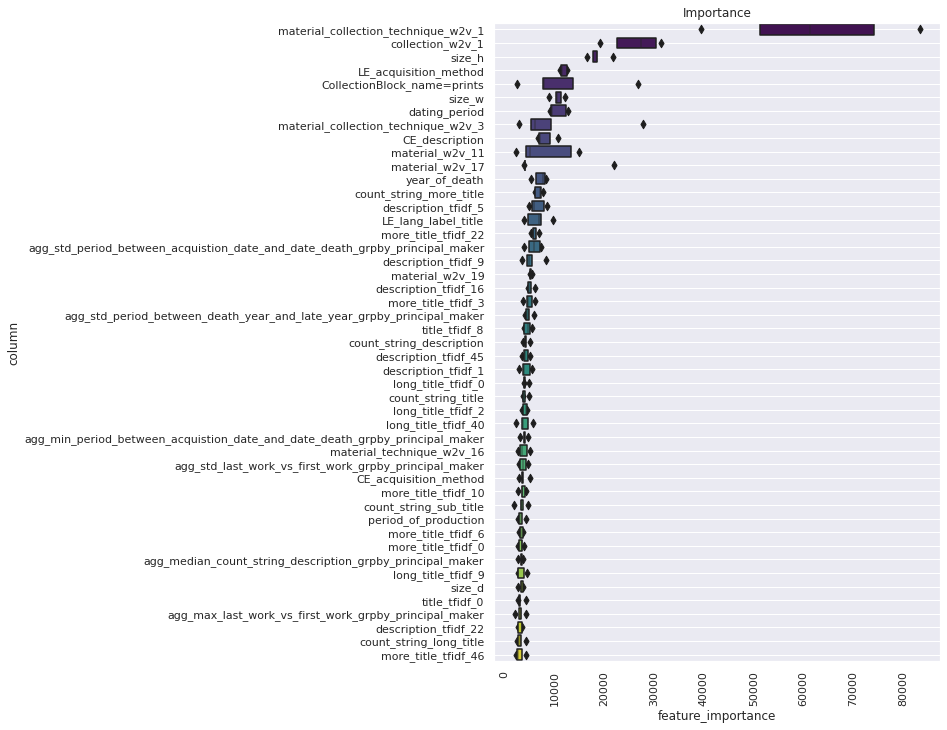

In [88]:
fig, _ = visualize_importance(models, feat_train_df=train_feat_df)

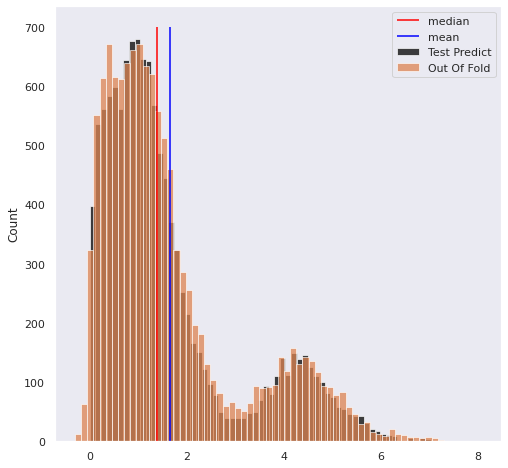

In [89]:

def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred


pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })

fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
plt.vlines(np.median(np.log1p(train_df["likes"])), ymin=0, ymax=700, color="red", label="median")
plt.vlines(np.mean(np.log1p(train_df["likes"])), ymin=0, ymax=700, color="blue", label="mean")
ax.legend()
ax.grid()

In [91]:
sub_df.to_csv(OUTPUT_PAHT + 'add_tfidf_feature.csv', index=False)